# DHyrbidR Pipeline Developement
Here is a notebook where we willd develop the DHybridR FPC analysis pipeline.

Goal: To take DHybridR simulation data, due FPC analysis on it, and put these FPC velocity space signatures into a suitable netcdf4 file to pass on to collaborators training the MLA algorithm which will autonomously detect shocks and other wave modes

In [1]:
#needed libraries
import pickle
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

#debug libraries
import time
from sys import getsizeof
printruntime = True

## Load DHyribdR data

### Functions used to load data

In [2]:
#Function to load fields
def field_loader(field_vars='all', components='all', num=None,
                 path='./', slc=None, verbose=False):
    if(slc != None):
        print("Warning: taking slices of field data is currently unavailable. TODO: fix")
        return {}
    
    
    _field_choices_ = {'B':'Magnetic',
                       'E':'Electric',
                       'J':'CurrentDens'}
    _ivc_ = {v: k for k, v in iter(_field_choices_.items())}
    if components == 'all':
        components = 'xyz'
    if path[-1] is not '/': path = path + '/'
    fpath = path+"Output/Fields/*"
    if field_vars == 'all':
        field_vars = [c[len(fpath)-1:] for c in glob.glob(fpath)]
        field_vars = [_ivc_[k] for k in field_vars]
    else:
        if isinstance(field_vars, basestring):
            field_vars = field_vars.upper().split()
        elif not type(field_vars) in (list, tuple):
            field_vars = [field_vars]
    if slc is None:
        slc = np.s_[:,:]
    fpath = path+"Output/Fields/{f}/{T}{c}/{v}fld_{t}.h5"
    T = '' if field_vars[0] == 'J' else 'Total/'
    test_path = fpath.format(f = _field_choices_[field_vars[0]],
                             T = T,
                             c = 'x',
                             v = field_vars[0],
                             t = '*')
    if verbose: print(test_path)
    choices = glob.glob(test_path)
    #num_of_zeros = len()
    choices = [int(c[-11:-3]) for c in choices]
    choices.sort()
    fpath = fpath.format(f='{f}', T='{T}', c='{c}', v='{v}', t='{t:08d}')
    d = {}
    while num not in choices:
        _ =  'Select from the following possible movie numbers: '\
             '\n{0} '.format(choices)
        num = int(input(_))
    for k in field_vars:
        T = '' if k == 'J' else 'Total/'
        for c in components:
            ffn = fpath.format(f = _field_choices_[k],
                               T = T,
                               c = c,
                               v = k,
                               t = num)
            kc = k.lower()+c
            if verbose: print(ffn)
            with h5py.File(ffn,'r') as f:
                d[kc] = np.asarray(f['DATA'][slc],order='F')
                d[kc] = np.ascontiguousarray(d[kc])
                _N3,_N2,_N1 = f['DATA'].shape #python is fliped.
                x1,x2,x3 = f['AXIS']['X1 AXIS'][:], f['AXIS']['X2 AXIS'][:], f['AXIS']['X3 AXIS'][:] #TODO: double check that x1->xx x2->yy x3->zz
                dx1 = (x1[1]-x1[0])/_N1
                dx2 = (x2[1]-x2[0])/_N2
                dx3 = (x3[1]-x3[0])/_N3
                d[kc+'_xx'] = dx1*np.arange(_N1) + dx1/2. + x1[0]
                d[kc+'_yy'] = dx2*np.arange(_N2) + dx2/2. + x2[0]
                d[kc+'_zz'] = dx3*np.arange(_N3) + dx3/2. + x3[0]
                d[kc+'_xx'] = d[kc+'_xx']#[slc[1]]
                d[kc+'_yy'] = d[kc+'_yy']#[slc[0]]
                d[kc+'_zz'] = d[kc+'_zz']#[slc[0]]  #TODO: check if this is correct. Dont understand the variable slc or how it's used
    
    
    return d

#Loads vx, vy, xx, yy data only.
#Sometimes this is necessary to save RAM
def readParticlesPosandVelocityOnly(path, num):
    pts = {}
    twoDdist_vars = 'p1 p2 x1 x2'.split() #only need to load velocity and space information for dist func
    with h5py.File(path.format(num),'r') as f:
        for k in twoDdist_vars:
            pts[k] = f[k][:]
    return pts

In [7]:
#paths to data
path_particles = "M03/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path_fields = "M03/"

numframe = 1000 #used when naming files. Grabs the 1000th frame file
#Load fields
if(printruntime):
    start_time = time.time()
dfields = field_loader(path=path_fields,num=numframe)
if(printruntime):
    print("Time to load fields: %s seconds " % (time.time() - start_time))

Time to load fields: 0.15647387504577637 seconds 


In [8]:
#Define parameters from simulation
#TODO: load this automatically from input file
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
yShock = 0.0

In [9]:
#Look at data's shape and keys
print(type(dfields))
print(dfields.keys())

for key in dfields.keys():
    print('Shape of ' + str(key) + ': ' + str(np.shape(dfields[key])))

<class 'dict'>
dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz'])
Shape of bx: (48, 48, 192)
Shape of bx_xx: (192,)
Shape of bx_yy: (48,)
Shape of bx_zz: (48,)
Shape of by: (48, 48, 192)
Shape of by_xx: (192,)
Shape of by_yy: (48,)
Shape of by_zz: (48,)
Shape of bz: (48, 48, 192)
Shape of bz_xx: (192,)
Shape of bz_yy: (48,)
Shape of bz_zz: (48,)
Shape of ex: (48, 48, 192)
Shape of ex_xx: (192,)
Shape of ex_yy: (48,)
Shape of ex_zz: (48,)
Shape of ey: (48, 48, 192)
Shape of ey_xx: (192,)
Shape of ey_yy: (48,)
Shape of ey_zz: (48,)
Shape of ez: (48, 48, 192)
Shape of ez_xx: (192,)
Shape of ez_yy: (48,)
Shape of ez_zz: (48,)


In [10]:
#Load particle data
if(printruntime):
    start_time = time.time()
dparticles = readParticlesPosandVelocityOnly(path_particles, numframe)
if(printruntime):
    print("Time to run this: %s seconds " % (time.time() - start_time))

Time to run this: 22.48694086074829 seconds 


In [11]:
#Look at data's shape and keys
print(type(dparticles))
print(dparticles.keys())

for key in dparticles.keys():
    print('Length of ' + str(key) + ': ' + str(len(dparticles[key])))

<class 'dict'>
dict_keys(['p1', 'p2', 'x1', 'x2'])
Length of p1: 718844517
Length of p2: 718844517
Length of x1: 718844517
Length of x2: 718844517


In [12]:
#Look at memory usage of particle data
sizetotal = 0
for key in dparticles.keys():
    sizetotal += getsizeof(dparticles[key])
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 10.71161837875843 gb


## Plot fields
This section is mostly used for debugging purposes

In [13]:
def plot_field(dfields, fieldkey, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0): 
    #TODO: check that data is ordered this way
    if(axis == '_zz'):
        fieldval = np.asarray([dfields[fieldkey][i][yyindex][zzindex] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'z'
    elif(axis == '_yy'):
        fieldval = np.asarray([dfields[fieldkey][xxindex][i][zzindex] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'y'
    elif(axis == '_xx'):
        fieldval = np.asarray([dfields[fieldkey][xxindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'x'
        
    fieldcoord = np.asarray(dfields[fieldkey+axis])
    
    plt.figure(figsize=(20,10))
    plt.xlabel(xlbl)
    plt.ylabel(fieldkey)
    plt.plot(fieldcoord,fieldval)
    plt.show()
    
def plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0):
    if(axis == '_zz'):
        ex = np.asarray([dfields['ex'][i][yyindex][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][i][yyindex][zzindex] for i in range(0,len(dfields['ey'+axis]))])
        ez = np.asarray([dfields['ez'][i][yyindex][zzindex] for i in range(0,len(dfields['ez'+axis]))])
        bx = np.asarray([dfields['bx'][i][yyindex][zzindex] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][i][yyindex][zzindex] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][i][yyindex][zzindex] for i in range(0,len(dfields['bz'+axis]))])
    elif(axis == '_yy'):
        ex = np.asarray([dfields['ex'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ez = np.asarray([dfields['ez'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        bx = np.asarray([dfields['bx'][xxindex][i][zzindex] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][xxindex][i][zzindex] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][xxindex][i][zzindex] for i in range(0,len(dfields['bz'+axis]))])
    elif(axis == '_xx'):
        ex = np.asarray([dfields['ex'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        ez = np.asarray([dfields['ez'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        bx = np.asarray([dfields['bx'][xxindex][yyindex][i] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][xxindex][yyindex][i] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][xxindex][yyindex][i] for i in range(0,len(dfields['bz'+axis]))])
    
    fieldcoord = np.asarray(dfields['ex'+axis]) #assumes all fields have same coordinates
    
    fig, axs = plt.subplots(6,figsize=(20,10))
    axs[0].plot(fieldcoord,ex,label="ex")
    axs[0].set_ylabel("$ex$")
    axs[1].plot(fieldcoord,ey,label='ey')
    axs[1].set_ylabel("$ey$")
    axs[2].plot(fieldcoord,ez,label='ez')
    axs[2].set_ylabel("$ez$")
    axs[3].plot(fieldcoord,bx,label='bx')
    axs[3].set_ylabel("$bx$")
    axs[4].plot(fieldcoord,by,label='by')
    axs[4].set_ylabel("$by$")
    axs[5].plot(fieldcoord,bz,label='bz')
    axs[5].set_ylabel("$bz$")
    if(axis == '_xx'):
        axs[5].set_xlabel("$x$")
    elif(axis == '_yy'):
        axs[5].set_xlabel("$y$")
    elif(axis == '_yy'):
        axs[5].set_xlabel("$z$")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

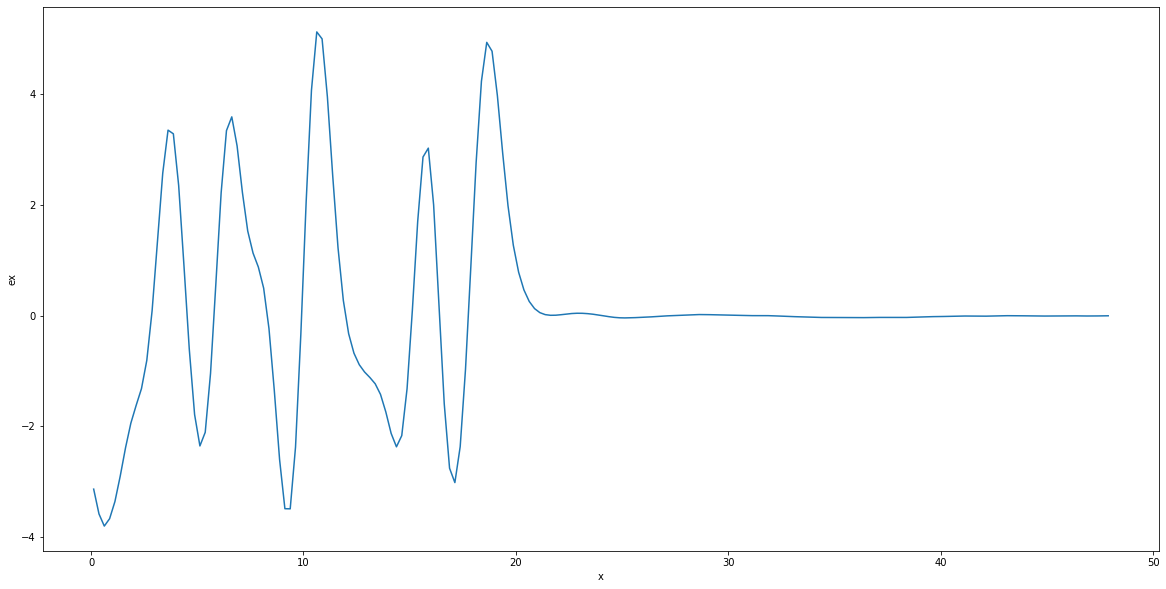

In [14]:
plot_field(dfields, 'ex')

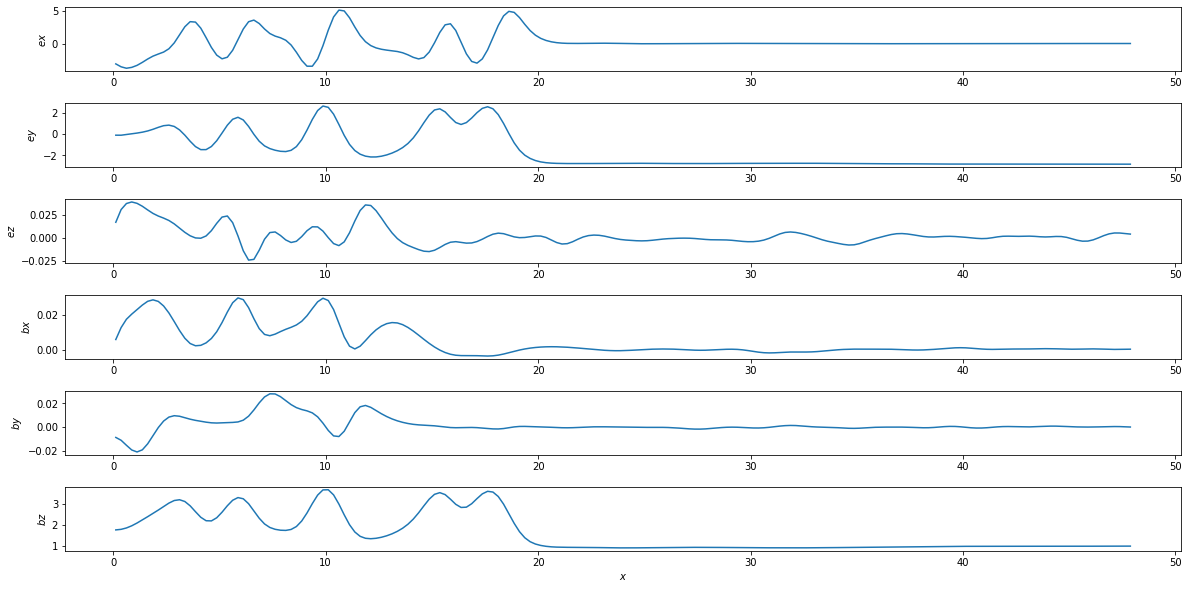

In [15]:
plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine bounds for metadata = 1

#### Determine bounds for metadata = 1

In [16]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

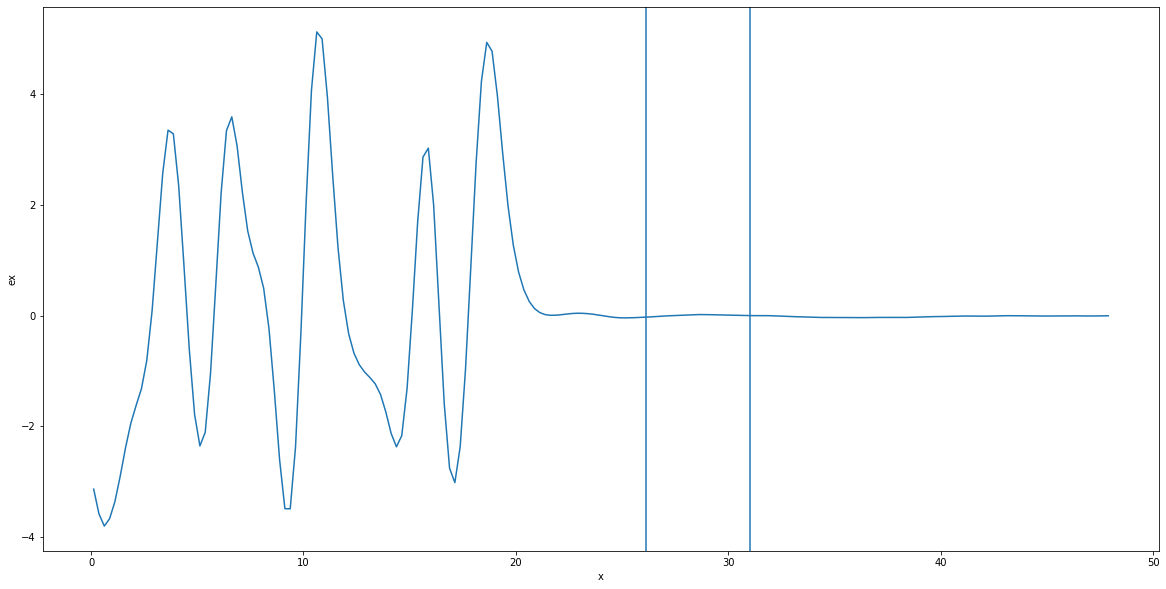

In [17]:
axis='_xx'
fieldkey = 'ex'
yyindex = 0
zzindex = 0
startval = 26.1 #bounds for metadata = 1 (di)
endval = 31 #bounds for metadata = 1 (di)
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=startval)
plt.axvline(x=endval)
plt.show()

In [18]:
startidx = find_nearest(dfields[fieldkey+axis], startval)

In [19]:
endidx = find_nearest(dfields[fieldkey+axis], endval)

In [20]:
metadata = np.zeros(len(dfields['ex_xx']))
metadata = metadata.astype(int)
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
for i in range(0,len(metadata)):
    if(i >= startidx and i <= endidx):
        metadata[i] = 1
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
startidx

104

In [23]:
endidx

123

In [24]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

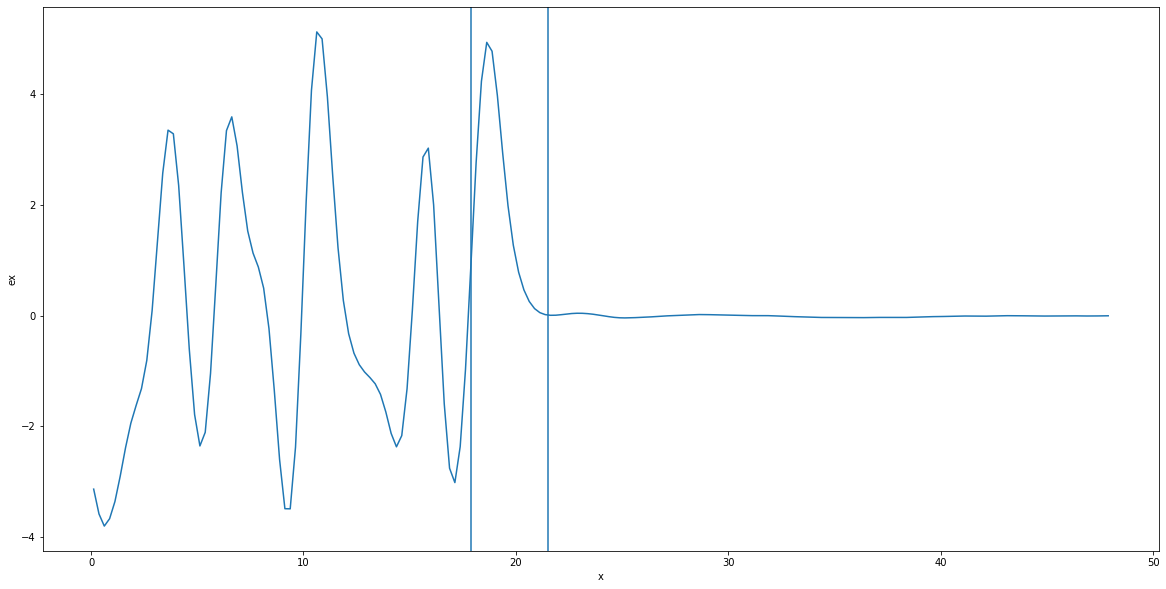

In [25]:
axis='_xx'
fieldkey = 'ex'
yyindex = 0
zzindex = 0
startval = 17.9 #bounds for metadata = 1 (di)
endval = 21.5 #bounds for metadata = 1 (di)
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=startval)
plt.axvline(x=endval)
plt.show()

In [26]:
xShock = endval

In [27]:
startidx = find_nearest(dfields[fieldkey+axis], startval)

In [28]:
endidx = find_nearest(dfields[fieldkey+axis], endval)

In [29]:
metadata = np.zeros(len(dfields['ex_xx']))
metadata = metadata.astype(int)
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
for i in range(0,len(metadata)):
    if(i >= startidx and i <= endidx):
        metadata[i] = 1
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [31]:
startidx

71

In [32]:
endidx

85

### Lorentz Transform fields

#### compute compression ratio and get V shock

In [33]:
def getcompressionration(dfields,xShock):
    #find ratio of downstream bz and upstream bz
    bzsumdownstrm = 0.
    bzsumupstrm = 0. 
    
    for i in range(0,len(dfields['bz'])):
        for j in range(0,len(dfields['bz'][i])):
            for k in range(0,len(dfields['bz'][i][j])):
                if(dfields['bz_xx'][k] > xShock):
                    bzsumupstrm += dfields['bz'][i][j][k]
                else:
                    bzsumdownstrm += dfields['bz'][i][j][k]
                                      
    return bzsumdownstrm/bzsumupstrm
                                      
                

In [36]:
r = getcompressionration(dfields,xShock)

In [37]:
Vinject = -3.0

In [38]:
Vshock = Vinject/(r-1.)

### apply transformation

In [39]:
#takes lorentz transform where V=(vx,0,0)
#TODO: check if units work (in particular where did gamma go. Perhaps we just assume it's small)
def lorentz_transform_vx(dfields,vx):
    import copy
    dfieldslor = copy.copy(dfields) #deep copy
    
    dfieldslor['ex'] = dfields['ex']
    dfieldslor['ey'] = dfields['ey']-vx*dfields['bz']
    dfieldslor['ez'] = dfields['ez']+vx*dfields['by']
    dfieldslor['bx'] = dfields['bx']
    dfieldslor['by'] = dfields['by']#assume v/c^2 is small
    dfieldslor['bz'] = dfields['bz']#assume v/c^2 is small
    
    return dfieldslor

In [40]:
dfields = lorentz_transform_vx(dfields,Vinject)

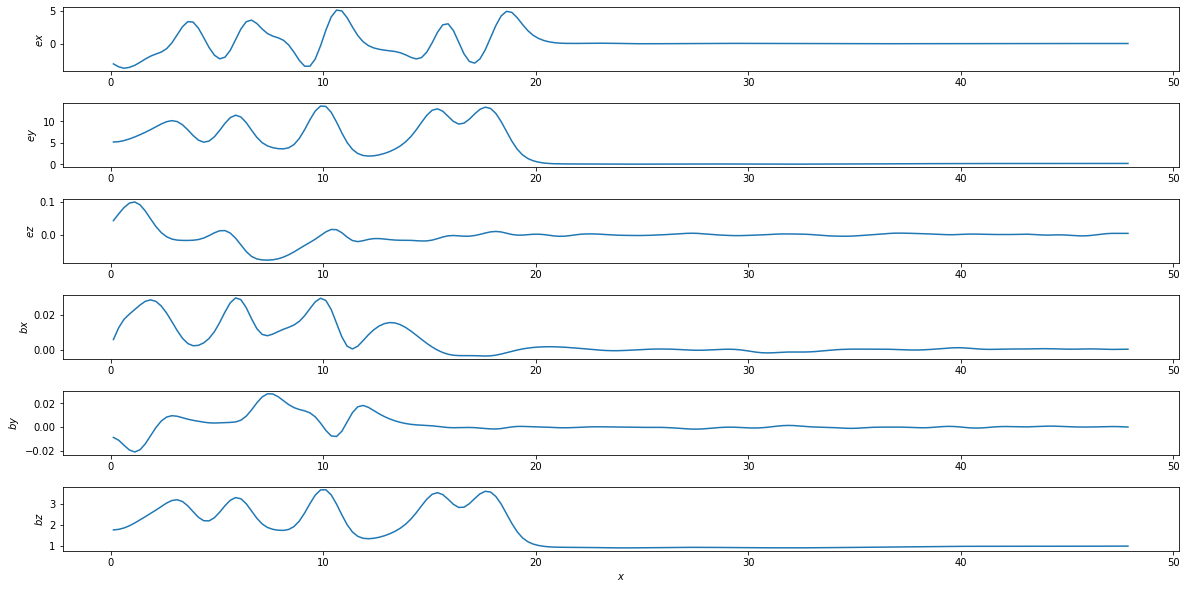

In [41]:
plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

## Analyze Fields


### Functions used to analyze fields

In [42]:
#finds the index of the two elements in an array closest to some given value
#assumes given array is ordered
def find_two_nearest(array, value):
    array = np.asarray(array)
    idx1 = (np.abs(array - value)).argmin()
    if(idx1 == 0): #if on left boundary
        idx2 = 1
    elif(idx1 == len(array)-1): #if on right boundary
        idx2 = len(array)-2
    elif(np.abs(array[idx1+1]-value) < np.abs(array[idx1-1]-value)):
        idx2 = idx1+1
    else:
        idx2 = idx1-1
    return idx1,idx2

In [43]:
# #returns weight for getting average field value within a cell 
# def get_3d_weights(xx,yy,zz,idxxx1,idxxx2,idxyy1,idxyy2,idxzz1,idxzz2,dfields,fieldkey):
#     #get weights by 'volume fraction' of cell
#     w1 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w2 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w3 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w4 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w5 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w6 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w7 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w8 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
    
#     #get volume
#     #Here we must find opposite corners of the box to ensure we get a 3d volume
#     #We find opposite corners by  sides of the box are all in either the xy,xz, or yz plane
#     #Note: this might only work when the cell walls are in the xy,xz,yz planes
#     maxxx = max(dfields[fieldkey+'_xx'][idxxx1],dfields[fieldkey+'_xx'][idxxx2])
#     maxyy = max(dfields[fieldkey+'_yy'][idxyy1],dfields[fieldkey+'_yy'][idxyy2])
#     maxzz = max(dfields[fieldkey+'_zz'][idxzz1],dfields[fieldkey+'_zz'][idxzz2])
#     minxx = min(dfields[fieldkey+'_xx'][idxxx1],dfields[fieldkey+'_xx'][idxxx2])
#     minyy = min(dfields[fieldkey+'_yy'][idxyy1],dfields[fieldkey+'_yy'][idxyy2])
#     minzz = min(dfields[fieldkey+'_zz'][idxzz1],dfields[fieldkey+'_zz'][idxzz2])
#     vol = abs((maxxx-minxx)*(maxyy-minyy)*(maxzz-minzz))
    
#     if(vol == 0.):
#         print("Error in getting weights! Found a zero volume.")
    
#     print(vol)
#     print(dfields[fieldkey+'_xx'][idxxx1]-xx)
#     print(dfields[fieldkey+'_xx'][idxxx1])
#     print(xx)
    
#     #normalize to one
#     w1 /= vol
#     w2 /= vol
#     w3 /= vol
#     w4 /= vol
#     w5 /= vol
#     w6 /= vol
#     w7 /= vol
#     w8 /= vol
    
#     #debug (should sum to 1)
#     if(True):
#         print('sum of weights: ' + str(w1+w2+w3+w4+w5+w6+w7+w8))
#         print(w1,w2,w3,w4,w5,w6,w7,w8)
        
#     return w1,w2,w3,w4,w5,w6,w7,w8

In [44]:
# #estimates the field at some point within a cell by taking a weighted average of the surronding grid points
# #NOTE: this assumes the sides of the box are all in either the xy,xz, or yz plane
# #TODO:FIX (weight is no longer 1?)
# def weighted_field_average(xx, yy, zz, dfields, fieldkey):
#     idxxx1, idxxx2 = find_two_nearest(dfields[fieldkey+'_xx'],xx)
#     idxyy1, idxyy2 = find_two_nearest(dfields[fieldkey+'_yy'],yy)
#     idxzz1, idxzz2 = find_two_nearest(dfields[fieldkey+'_zz'],zz)
    
#     #find weights
#     w1,w2,w3,w4,w5,w6,w7,w8 = get_3d_weights(xx,yy,zz,idxxx1,idxxx2,idxyy1,idxyy2,idxzz1,idxzz2,dfields,fieldkey)
    
    
#     #TODO: fix indexing here
#     #take average of field
#     fieldaverage = w1*dfields[fieldkey][idxzz1][idxyy1][idxxx1]
#     fieldaverage +=w2*dfields[fieldkey][idxzz1][idxyy1][idxxx2]
#     fieldaverage +=w3*dfields[fieldkey][idxzz1][idxyy2][idxxx1]
#     fieldaverage +=w4*dfields[fieldkey][idxzz2][idxyy1][idxxx1]
#     fieldaverage +=w5*dfields[fieldkey][idxzz1][idxyy2][idxxx2]
#     fieldaverage +=w6*dfields[fieldkey][idxzz2][idxyy2][idxxx2]
#     fieldaverage +=w7*dfields[fieldkey][idxzz2][idxyy2][idxxx1]
#     fieldaverage +=w8*dfields[fieldkey][idxzz2][idxyy1][idxxx2]
    
#     #debug
#     if(True):
#         print('fields:')
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print('weights')
#         print(w1)
#         print(w2)
#         print(w3)
#         print(w4)
#         print(w5)
#         print(w6)
#         print(w7)
#         print(w8)
    
#     return fieldaverage

In [45]:
#makes distribution and takes correlation wrt given field
#WARNING: this will average the fields within the specified bounds. 
#However, if there are no gridpoints within the specified bounds
#it will *not* grab the field value at the nearest gridpoint and break. TODO: grab nearest field when range is small
def make2dHistandCey(vmax, dv, x1, x2, y1, y2, dpar, dfields, fieldkey):

    #find average E field based on provided bounds
    gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])  & (dfields[fieldkey+'_xx'] <= x2)
    gfieldptsy = (y1 <= dfields[fieldkey+'_yy']) & (dfields[fieldkey+'_yy'] <= y2)

    goodfieldpts = []
    for i in range(0,len(dfields['ex_xx'])):
        for j in range(0,len(dfields['ex_yy'])):
            for k in range(0,len(dfields['ex_zz'])):
                if(gfieldptsx[i] == True and gfieldptsy[j] == True):
                    goodfieldpts.append(dfields[fieldkey][k][j][i])
      
    #TODO?: consider forcing user to take correlation over only 1 cell
    if(len(goodfieldpts)==0):
        print("Using weighted_field_average...") #Debug
        avgfield = weighted_field_average((x1+x2)/2.,(y1+y2)/2.,0,dfields,fieldkey) #TODO: make 3d i.e. *don't* just 'project' all z information out and take fields at z = 0
    else:              
        avgfield = np.average(goodfieldpts)
    totalFieldpts = np.sum(goodfieldpts)

    #define mask that includes particles within range
    gptsparticle = (x1 < dpar['x1'] ) & (dpar['x1'] < x2) & (y1 < dpar['x2']) & (dpar['x2'] < y2)
    totalPtcl = np.sum(gptsparticle)
    
    #make bins
    vxbins = np.arange(-vmax, vmax, dv)
    vx = (vxbins[1:] + vxbins[:-1])/2.
    vybins = np.arange(-vmax, vmax, dv)
    vy = (vybins[1:] + vybins[:-1])/2.
    
    #make the bins 2d arrays
    _vx = np.zeros((len(vy),len(vx)))
    _vy = np.zeros((len(vy),len(vx)))
    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vx[i][j] = vx[j]

    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vy[i][j] = vy[i]

    vx = _vx
    vy = _vy
    
    #find distribution
    Hxy,_,_ = np.histogram2d(dpar['p2'][gptsparticle],dpar['p1'][gptsparticle],
                         bins=[vybins, vxbins])
    
    #calculate correlation
    Cey = -0.5*vy**2*np.gradient(Hxy, dv, edge_order=2, axis=0)*avgfield 
    return vx, vy, totalPtcl, totalFieldpts, Hxy, Cey

In [46]:
#makes distribution and takes correlation wrt given field
#WARNING: this will average the fields within the specified bounds. 
#However, if there are no gridpoints within the specified bounds
#it will *not* grab the field value at the nearest gridpoint and break. TODO: grab nearest field when range is small
def make2dHistandCex(vmax, dv, x1, x2, y1, y2, dpar, dfields, fieldkey):

    #find average E field based on provided bounds
    gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])  & (dfields[fieldkey+'_xx'] <= x2)
    gfieldptsy = (y1 <= dfields[fieldkey+'_yy']) & (dfields[fieldkey+'_yy'] <= y2)

    goodfieldpts = []
    for i in range(0,len(dfields['ex_xx'])):
        for j in range(0,len(dfields['ex_yy'])):
            for k in range(0,len(dfields['ex_zz'])):
                if(gfieldptsx[i] == True and gfieldptsy[j] == True):
                    goodfieldpts.append(dfields[fieldkey][k][j][i])
    
    if(len(goodfieldpts)==0):
        print("Warning, no field grid points in given box. Please increase box size or center around grid point.")
    
    avgfield = np.average(goodfieldpts)
    totalFieldpts = np.sum(goodfieldpts)

    #define mask that includes particles within range
    gptsparticle = (x1 < dpar['x1'] ) & (dpar['x1'] < x2) & (y1 < dpar['x2']) & (dpar['x2'] < y2)
    totalPtcl = np.sum(gptsparticle)
    
    #make bins
    vxbins = np.arange(-vmax, vmax, dv)
    vx = (vxbins[1:] + vxbins[:-1])/2.
    vybins = np.arange(-vmax, vmax, dv)
    vy = (vybins[1:] + vybins[:-1])/2.
    
    #make the bins 2d arrays
    _vx = np.zeros((len(vy),len(vx)))
    _vy = np.zeros((len(vy),len(vx)))
    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vx[i][j] = vx[j]

    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vy[i][j] = vy[i]

    vx = _vx
    vy = _vy
    
    #find distribution
    Hxy,_,_ = np.histogram2d(dpar['p2'][gptsparticle],dpar['p1'][gptsparticle],
                         bins=[vybins, vxbins])
    
    #calculate correlation
    Cex = -0.5*vx**2*np.gradient(Hxy, dv, edge_order=2, axis=1)*avgfield
    return vx, vy, totalPtcl, totalFieldpts, Hxy, Cex

In [47]:
vmax

15.0

In [48]:
xShock

21.5

In [50]:
if(printruntime):
    start_time = time.time()
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xShock, xShock+dx, 0, max(dfields['ey_yy']), dparticles, dfields, 'ey')
if(printruntime):
    print("Time to run correlation: %s seconds " % (time.time() - start_time))

Time to run correlation: 6.462403059005737 seconds 


## Plot FPCs/ Velocity Space Signatures
This section is mostly used for debugging purposes

In [54]:
def plot_velsig(vx,vy,vmax,Ce,fieldkey,flnm = '',ttl=''):
    plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

    maxCe = max(np.max(Ce),np.max(abs(Ce)))
    
    #ordering when plotting is flipped
    #see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
    plotv1 = vx#np.flip(vx)
    plotv2 = vy#np.flip(vy)
    
    plt.figure(figsize=(6.5,6))
    plt.figure(figsize=(6.5,6))
    plt.pcolormesh(plotv1, plotv2, Ce, vmax=maxCe, vmin=-maxCe, cmap="seismic", shading="gouraud")
    plt.xlim(-vmax, vmax)
    plt.ylim(-vmax, vmax)
    plt.xticks(np.linspace(-vmax, vmax, 9))
    plt.yticks(np.linspace(-vmax, vmax, 9))
    plt.title(ttl+" $C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
    plt.xlabel(r"$v_x/v_{ti}$")
    plt.ylabel(r"$v_y/v_{ti}$")
    plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
    clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
    plt.setp(plt.gca(), aspect=1.0)
    plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
    if(flnm != ''):
        plt.savefig(flnm+'.png',format='png')
        plt.close('all')#saves RAM
    else:
        plt.show()
    plt.close()

<Figure size 468x432 with 0 Axes>

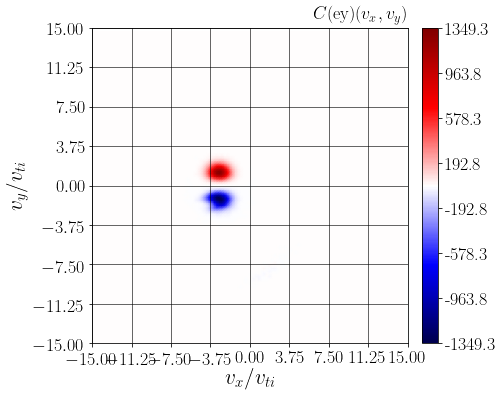

In [55]:
plot_velsig(vx,vy,vmax,Cey_quarterdi,'ey')

## Do full bulk analysis

In [58]:
xsweep = 0.0
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
dv = 0.25

CEx_out = []
CEy_out = []
x_out = []
Hxy_out = []

for i in range(0,len(dfields['ex_xx'])):
    print(str(dfields['ex_xx'][i]) +' of ' + str(dfields['ex_xx'][len(dfields['ex_xx'])-1]))
    #to do full 'bulk analysis' we loop over one of these three blocks for all desired sections along x
    vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, 'ey')
    vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cex_quarterdi = make2dHistandCex(vmax, dv, xsweep, xsweep+dx, dfields['ex_xx'][0], dfields['ex_xx'][1], dparticles, dfields, 'ex')
    x_out.append(np.mean([xsweep,xsweep+dx]))
    CEy_out.append(Cey_quarterdi)
    CEx_out.append(Cex_quarterdi)
    Hxy_out.append(Hxy_quarterdi)
    xsweep+=dx

0.125 of 47.875
0.375 of 47.875
0.625 of 47.875
0.875 of 47.875
1.125 of 47.875
1.375 of 47.875
1.625 of 47.875
1.875 of 47.875
2.125 of 47.875
2.375 of 47.875
2.625 of 47.875
2.875 of 47.875
3.125 of 47.875
3.375 of 47.875
3.625 of 47.875
3.875 of 47.875
4.125 of 47.875
4.375 of 47.875
4.625 of 47.875
4.875 of 47.875
5.125 of 47.875
5.375 of 47.875
5.625 of 47.875
5.875 of 47.875
6.125 of 47.875
6.375 of 47.875
6.625 of 47.875
6.875 of 47.875
7.125 of 47.875
7.375 of 47.875
7.625 of 47.875
7.875 of 47.875
8.125 of 47.875
8.375 of 47.875
8.625 of 47.875
8.875 of 47.875
9.125 of 47.875
9.375 of 47.875
9.625 of 47.875
9.875 of 47.875
10.125 of 47.875
10.375 of 47.875
10.625 of 47.875
10.875 of 47.875
11.125 of 47.875
11.375 of 47.875
11.625 of 47.875
11.875 of 47.875
12.125 of 47.875
12.375 of 47.875
12.625 of 47.875
12.875 of 47.875
13.125 of 47.875
13.375 of 47.875
13.625 of 47.875
13.875 of 47.875
14.125 of 47.875
14.375 of 47.875
14.625 of 47.875
14.875 of 47.875
15.125 of 47.875
15.

## Make Netcdf4 file
Be careful that orientation is preserved. Make sure to check this (see above field plots)

In [63]:
#define attributes/ simulation parameters
params = {}
params["MachAlfven"] = abs(Vshock)
params["MachAlfvenNote"] = 'TODO: compute mach alfven for this run'
params["ShockNormalAngle"] = 90.0
params["betaelec"] = 1.0
params["betaion"] = 1.0
params["simtime"] = 1000
params["simtimeNote"] = 'This is frames number for this data set. TODO: convert to inverse Omega_c,i'
params["qi"] = 1.0
params["di"] = 0.0
params["dinote"] = 'TODO: compute ion inertial length'
params["vti"] = 1.0

In [64]:
def savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = {}, filename = 'dHybridRSDAtest.nc' ):
    from netCDF4 import Dataset
    from datetime import datetime
    
    
    #normalize CEx, CEy to 1-------------------------------------------------------
    #Here we normalize to the maximum value in either CEx, CEy
    maxCval = max(np.amax(np.abs(CEx_out)),np.amax(np.abs(CEy_out)))
    CEx_out /= maxCval
    CEy_out /= maxCval
    

    # open a netCDF file to write
    ncout = Dataset(filename, 'w', format='NETCDF4')
    
        
    #save data in netcdf file-------------------------------------------------------
    #define attributes
    for key in params:
        setattr(ncout,key,params[key])
    ncout.description = 'dHybridR MLA data test 1'
    ncout.generationtime = str(datetime.now())

    #make dimensions that dependent data must 'match'
    ncout.createDimension('x', None)  # NONE <-> unlimited TODO: make limited if it saves memory or improves compression?
    ncout.createDimension('vx', None)
    ncout.createDimension('vy', None)
    
    vx = ncout.createVariable('vx','f4', ('vx',))
    vx.nvx = len(vx_out)
    vx.longname = 'v_x/v_ti'
    vx[:] = vx_out[:]
    
    vy = ncout.createVariable('vy','f4', ('vy',))
    vy.nvy = len(vy_out)
    vy.longname = 'v_y/v_ti'
    vy[:] = vy_out[:]

    x = ncout.createVariable('x','f4',('x',))
    x.nx = len(x_out)
    x[:] = x_out[:]

    #tranpose data to match previous netcdf4 formatting
    for i in range(0,len(CEx_out)):
        tempCex = CEx_out[i].T
        CEx_out[i] = tempCex
        tempCey = CEy_out[i].T
        CEy_out[i] = tempCey
    
    C_ex = ncout.createVariable('C_Ex','f4', ('x', 'vx', 'vy'))
    C_ex.longname = 'C_{Ex}'
    C_ex[:] = CEx_out[:]

    C_ey = ncout.createVariable('C_Ey','f4', ('x', 'vx', 'vy'))
    C_ey.longname = 'C_{Ey}'
    C_ey[:] = CEy_out[:]
    
    metadata = ncout.createVariable('metadata','f4',('x',))
    metadata.description = '1 = signature, 0 = no signature'
    metadata[:] = metadata_out[:]
    
    #Save data into netcdf4 file-----------------------------------------------------
    print("Saving data into netcdf4 file")

    #save file
    ncout.close()


In [65]:
#note: it seems jupyter does not have permission to overwrite files. Either change filename or delete conflicting file
#metadata = [1,1,1] #TODO: ID where shock is and set metadeta 
flnm = 'out.nc'
savedata(CEx_out,CEy_out,vx[0][:],np.asarray([vy[i][0] for i in range(0,len(vy))]),x_out,metadata_out=metadata,params=params,filename=flnm) #assumes uniform velocity grid

Saving data into netcdf4 file
